<a href="https://colab.research.google.com/github/matthewchung74/blogs/blob/dev/Dog_Pooping_Dectron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The **Dog Pooping in my yard Transformer Detectron** tutorial using Pytorch and Transformers!

The problem is some owners do not pick up their dog poop. I believe this is not a problem isolated to where I live, in the bay area, but is ubiquitious to the world. To combat this problem, I am working on the **Dog Pooping in my yard Transformer Detectron**.  

We're going to start with getting something working using transformers via the [Timm](https://github.com/rwightman/pytorch-image-models) library, then in parts 2, we'll unpack what is going on. In part 3, we'll put this into production so we can catch dogs pooping in my yard in the wild.

## Part 1

### The Data
Fortunately for us, we can simply wget and unzip some images I scrapped. The zip has two folders, one called `poop`, one called `no-poop`. There are 19 pooping images and 17 not-pooping. We'll save 4 for validation which leaves us 32 images for training.

In [69]:
!wget https://github.com/matthewchung74/dog-pooping-detectron/raw/main/data.zip
!unzip -qq -n data.zip -d data

--2021-02-09 01:14:23--  https://github.com/matthewchung74/dog-pooping-detectron/raw/main/data.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/matthewchung74/blogs/raw/main/data.zip [following]
--2021-02-09 01:14:23--  https://github.com/matthewchung74/blogs/raw/main/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewchung74/blogs/main/data.zip [following]
--2021-02-09 01:14:23--  https://raw.githubusercontent.com/matthewchung74/blogs/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

Now you may be wondering, how can we train off 32 images? If we need more images, I'm in trouble since I'm tired of downloading images of dogs pooping. Well, lucky for us, the answer is below. Just look for pretraining in the TIMM section.

Let's take a look at the data. We're going to create a dataset, split, do some transforms, and print out a batch.

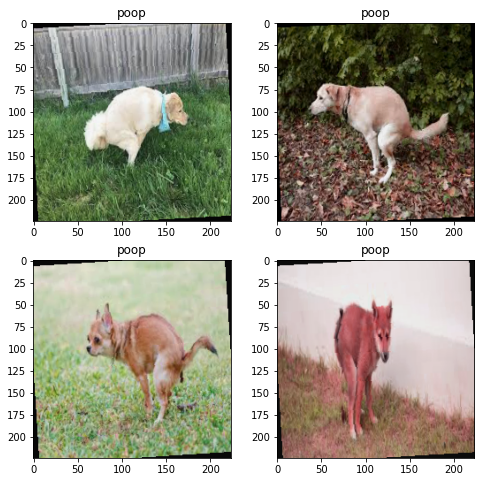

In [70]:
import glob
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "./data"
all_files = glob.glob(os.path.join(data_dir,'**/*.jpg'))
labels = [int('no-poop' not in label) for label in all_files] 

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

class PoopDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = self.labels[idx]
        return img_transformed, label

all_files_len = len(all_files)
train_dataset = PoopDataset(all_files[:all_files_len-4], labels[:all_files_len-4], transform=train_transforms)
train_loader = DataLoader(dataset = train_dataset, batch_size=4, shuffle=True )

valid_dataset = PoopDataset(all_files[all_files_len-4:], labels[all_files_len-4:], transform=test_transforms)
valid_loader = DataLoader(dataset = train_dataset, batch_size=4, shuffle=True )

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
images, labels = next(iter(train_loader)) 

for idx, ax in enumerate(axes.ravel()):
    img = transforms.ToPILImage()(images[idx])
    title = "poop" if labels[idx] == 1 else "no poop"
    ax.set_title(title)
    ax.imshow(img)

### Aren't Transformers for NLP?
Nope. This paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) changed all that. We will get more into the details in future parts. This tutorial is all about quickly being able to detect pooping dogs which you can take and apply to your own problem, such as cats pooping in your yard! 

First let's set our device to use the gpu

In [71]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### What is TIMM
[Timm](https://github.com/rwightman/pytorch-image-models) is the open source library we're goign to use to get up and running. If you have time, check out his repo. It is amazing. In a nutshell, it is a library of SOTA architectures with pre-trained weights.

1.   First, let's `pip` install it.
2.   Then let's look at all the models `list_models` that have pretraining, and match the wildcard `vit` which stands for visual transformer. We will pick the one we're interested in, `vit_base_patch16_224`
3.   Let's print out a summary.


In [72]:
!pip install timm

In [73]:
import timm
from pprint import pprint
model_names = timm.list_models('*vit*', pretrained=True)
pprint(model_names)

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224']


In [74]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = model.to(device)
model.head

Linear(in_features=768, out_features=1000, bias=True)

Now the model summary large, and we'll cover what it all means later, but for now, we'll focus on the last line `(head)`. This is the last layer which classifies to 1000 different classes. We only have 2, is it a pooping dog or not. So let's change that.

In [75]:
import torch.nn as nn
model.head = nn.Linear(768, 2).to(device)

### Standard training stuff
Let's do some standard pytorch training stuff. 

*   I'm going to set the batchsize to `35` since there are only 35 training samples
*   we're going to do 20 epochs which is arbitrary
*   we're going to guess at a reasonable learning rate and gamma.

In [76]:
epochs = 4
lr = 3e-5
gamma = 0.7

Now we're going to setup our `criterion`, `optimizer`, `scheduler` like any other pytorch project.


In [77]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

And now we're going to train much like any other pytorch training loop.

In [78]:
from tqdm.notebook import tqdm
import pdb

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(dtype=torch.long, device=device)
        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(dtype=torch.long, device=device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )



Epoch : 1 - loss : 0.6357 - acc: 0.6875 - val_loss : 0.3268 - val_acc: 0.9062




Epoch : 2 - loss : 0.2442 - acc: 0.8750 - val_loss : 0.1494 - val_acc: 0.9375




Epoch : 3 - loss : 0.1117 - acc: 1.0000 - val_loss : 0.0752 - val_acc: 1.0000




Epoch : 4 - loss : 0.0623 - acc: 1.0000 - val_loss : 0.0360 - val_acc: 1.0000



## Part 2

In this part, we'll explore look at the visual transformer source code within the [Timm](https://github.com/rwightman/pytorch-image-models) to get a better intuition for what is going on.

But first, let's look at this illustration


In [11]:
from IPython.display import Image
Image(url='https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s16000/image1.gif', width=600, height=412)

the Timm [VisionTransformer](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#L267) is the main model for this application and I encourage you to take a look at the source. It does everything that is shown in the image above.

### Patch Embedding
The first thing you see in the animated gif above is the image being split into 9 patches. If you follow the [VisionTransformer](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#L267) link, you'll see `PatchEmbed` being set. This is the main thing that separates vision transformers from others. 

In Github, I will right click on [PatchEmbed](https://github.com/rwightman/pytorch-image-models/blob/4203efa36d0258315f51ad8f945849586b058408/timm/models/vision_transformer.py#L203) or you can click on this link. You will see something very similar to the following.

In [12]:
from itertools import repeat
import pdb

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = tuple(repeat(img_size, 2))
        patch_size = tuple(repeat(patch_size, 2))
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

What this doing? Transformers take a 1D sequence of token embeddings, where every token knows something about every other token.

But what about with images? We could take an image and flatten it to 1D, and that might be fine for small images. But look at the example of a 250x250 pixel image, where every pixel knows a little something about every other pixel. We're talking 250^2 pixels with (250^2)^2 relations!

So instead of that, we can flatten and break into patches, in this case, patches of size 16. If we look at the math
```
width, height = 224
patch_size = 16
width / patch_size * height / patch_size = 196
```

Also, if we look at the default for embed_dim, it's 768, which means each of our patches will be 786 pixels long. Let's give it a shot.

In [13]:
from PIL import Image

loader = DataLoader(dataset = train_dataset, batch_size=1, shuffle=False )
first_batch = next(iter(loader))[0]
model = PatchEmbed()
patch_output = model(first_batch)
batch_size, num_patches, embedding = patch_output.shape
num_patches, embedding

(196, 768)

The image above has 16 patches where ours has 196 but the idea is the same. 

### Extra Learnable Class Embeddings

Now if you look at the animated gif, there are the two Extra Learnable Class Embeddings, which are passed into the Transformer Encoder. The first is the [pos_embed](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#L309) or positional embedding (0,1,2,...) and the second is the empty pill next to the position, the class embedding. Just looking at the [source](https://github.com/rwightman/pytorch-image-models/blob/b9843f954b0457af2db4f9dea41a8538f51f5d78/timm/models/vision_transformer.py#L361), we first concatenate the class tokens with the patches and then add the position embedding.
```
x = self.patch_embed(x)
cls_tokens = self.cls_token.expand(B, -1, -1)
x = torch.cat((cls_tokens, x), dim=1)
x = x + self.pos_embed
```

The next part of the animated gif we're going to focus on is the Transformer Encoder which is this [ModuleList](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#L313).
```
self.blocks = nn.ModuleList([
    Block(
        dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
        drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
    for i in range(depth)])
```

So we see this Block thing is stacked `depth` times. But what is [Block](https://github.com/rwightman/pytorch-image-models/blob/b9843f954b0457af2db4f9dea41a8538f51f5d78/timm/models/vision_transformer.py#L183)? Right click in Github or follow this link. You should see something similar to the following.

In [14]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

Looking at this code, it seems there are a few things we'll need to explore. But let's just run it to see what happens when we take this and combine with the inputs from above.

In [15]:
embed_dim = 768
num_heads = 8
block = Block(embed_dim, 8)

batch_size = 1
class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
class_tokens = class_token.expand(batch_size, -1, -1)
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

x = torch.cat((class_tokens, patch_output), dim=1)
x = x + pos_embed

block(x)

NameError: ignored

Uh oh.

So let's explore what [Attention](https://github.com/rwightman/pytorch-image-models/blob/b9843f954b0457af2db4f9dea41a8538f51f5d78/timm/models/vision_transformer.py#L155) is. First, let's get the overall picture with this image from [Peter Bloem](http://peterbloem.nl/blog/transformers). For more details on this, the [Peter Bloem](http://peterbloem.nl/blog/transformers) tutorial is very good.

In [16]:
from IPython.display import Image
Image(url='https://github.com/matthewchung74/blogs/raw/dev/key-query-value.jpg', width=600, height=550)

From the above, we can see 3 weight matrixes `Wq`, `Wk` and `Wv` which stand for `queries`, `keys` and `values`. They are trained parameters which we'll explore more in the code below but at a high level:


1.   `Wq`, `Wk` and `Wv` are all multiplied by the incoming embedded vector to form `q`, `k`, `v`.
2.   `q` and `k` are multiplied and softmaxed to give `w`
3.   `w` is multplied by `v` and summed to form `y`


Let's take a look at the [Attention](https://github.com/rwightman/pytorch-image-models/blob/b9843f954b0457af2db4f9dea41a8538f51f5d78/timm/models/vision_transformer.py#L155) source code. If you follow the link, it will take you to something similar to this. 

In [17]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) # create qkv
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   

        attn = (q @ k.transpose(-2, -1)) * self.scale # q multiplied by k
        attn = attn.softmax(dim=-1)  # softmax
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

We can see the `q`, `k`, `v` are created by the output of a linear layer. Later in the `forward` we can see `q` multiplied by `k` followed by a `softmax` then finally multipied by `v`

In [18]:
embed_dim = 768
num_heads = 8
block = Block(embed_dim, 8)

batch_size = 1
class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
class_tokens = class_token.expand(batch_size, -1, -1)
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

x = torch.cat((class_tokens, patch_output), dim=1)
x = x + pos_embed

block(x)

NameError: ignored

Uh oh.

### Mlp head

Luckily this one is more straight forward. If you look at the animated gif, the last step is a Mlp head, which is just some linear layers with dropout. Let's define it below and try again.

In [19]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [20]:
embed_dim = 768
num_heads = 8
block = Block(embed_dim, 8)

batch_size = 1
class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
class_tokens = class_token.expand(batch_size, -1, -1)
pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

x = torch.cat((class_tokens, patch_output), dim=1)
x = x + pos_embed

block(x)

tensor([[[ 0.1428,  0.1630, -0.4572,  ...,  0.1218,  0.1497, -0.0847],
         [ 0.2122,  0.2693, -0.4727,  ...,  0.0169,  0.2624, -0.0494],
         [ 0.3903,  0.1296, -0.4568,  ...,  0.0581,  0.3309, -0.0177],
         ...,
         [ 0.6364,  0.2511, -0.4204,  ...,  0.1226,  0.2689,  0.1262],
         [ 0.5271,  0.3288, -0.4904,  ...,  0.0252,  0.2650,  0.0517],
         [ 0.2147,  0.2437, -0.4282,  ...,  0.2999,  0.0380, -0.0330]]],
       grad_fn=<AddBackward0>)

And that's it. In our training loop, we do this calculation many many times, but this should give you enough to dive into the source code and explore yourself.

references
* https://github.com/rwightman/pytorch-image-models
* http://peterbloem.nl/blog/transformers
* https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html

In [ ]:
!pip install coremltools -qq

In [88]:
model.eval()
example_input = torch.rand(1,3,224,224).cuda()
traced_model = torch.jit.trace(model, example_input)

AttributeError: ignored

In [86]:
import coremltools as ct
# Convert to Core ML using the Unified Conversion API
ct_model = ct.convert(
    scripted_model,
    inputs=[ct.ImageType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
    classifier_config = ct.ClassifierConfig(["no poop","poop"]) # provide only if step 2 was performed
)

Translating MIL ==> MLModel Ops: 100%|██████████| 836/836 [00:11<00:00, 73.90 ops/s]


In [87]:
ct_model.save("poop.mlmodel")

In [84]:
# Download class labels (from a separate file)
import urllib
label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()

class_labels = class_labels[1:] # remove the first class which is background
class_labels[:3]

['tench', 'goldfish', 'great white shark']

In [59]:
model.eval()
scripted_model = torch.jit.script(model)

import coremltools
mlmodel = coremltools.converters.convert(
  scripted_model,
  inputs=[coremltools.TensorType(shape=(1, 3, 64, 64))],
)

Converting Frontend ==> MIL Ops:   0%|          | 0/10 [00:00<?, ? ops/s]
Converting Frontend ==> MIL Ops: 0 ops [00:00, ? ops/s]

Converting Frontend ==> MIL Ops: 0 ops [00:00, ? ops/s]

Converting Frontend ==> MIL Ops:   0%|          | 0/6 [00:00<?, ? ops/s]

Translating MIL ==> MLModel Ops:   0%|          | 0/12 [00:00<?, ? ops/s]
Translating MIL ==> MLModel Ops: 0 ops [00:00, ? ops/s]

Translating MIL ==> MLModel Ops: 0 ops [00:00, ? ops/s]

Translating MIL ==> MLModel Ops: 100%|██████████| 2/2 [00:00<00:00, 7339.11 ops/s]

Translating MIL ==> MLModel Ops: 100%|██████████| 12/12 [00:00<00:00, 800.92 ops/s]


In [53]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [57]:
import torch.nn.functional as F

class _LoopBody(nn.Module):
    def __init__(self, channels):
        super(_LoopBody, self).__init__()
        conv = nn.Conv2d(
            in_channels=channels,
            out_channels=channels,
            kernel_size=3,
            padding=1,
        )
        self.conv = conv

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x

class ControlFlowNet(nn.Module):
    def __init__(self, num_channels: int):
        super(ControlFlowNet, self).__init__()
        self.loop_body = _LoopBody(num_channels)

    def forward(self, x):
        avg = torch.mean(x)
        if avg.item() < 0:
            loop_count = 2
        else:
            loop_count = 1
        for _ in range(loop_count):
            x = self.loop_body(x)
        return x

In [58]:
model = ControlFlowNet(num_channels=3)
scripted_model = torch.jit.script(model)

import coremltools
mlmodel = coremltools.converters.convert(
  scripted_model,
  inputs=[coremltools.TensorType(shape=(1, 3, 64, 64))],
)

Converting Frontend ==> MIL Ops:   0%|          | 0/10 [00:00<?, ? ops/s]
Converting Frontend ==> MIL Ops: 0 ops [00:00, ? ops/s]

Converting Frontend ==> MIL Ops: 0 ops [00:00, ? ops/s]

Converting Frontend ==> MIL Ops:   0%|          | 0/6 [00:00<?, ? ops/s]

Translating MIL ==> MLModel Ops:   0%|          | 0/12 [00:00<?, ? ops/s]
Translating MIL ==> MLModel Ops: 0 ops [00:00, ? ops/s]

Translating MIL ==> MLModel Ops: 0 ops [00:00, ? ops/s]

Translating MIL ==> MLModel Ops: 100%|██████████| 2/2 [00:00<00:00, 6887.20 ops/s]

Translating MIL ==> MLModel Ops: 100%|██████████| 12/12 [00:00<00:00, 880.12 ops/s]
